<h1>Ditchley S2DS project August 2020 - Pipeline B<h1>
    <h2>Team: Adam Hawken, Luca Lamoni, Elizabeth Nicholson, Robert Webster<h2>
        
This notebook (B_pipeline) will be dedicated to:
- B1: Working directory and keyword setting
- B2: Selection of inliers based on distribution of friends and followers (optional)       
- B3: Download equal amounts of journalists and friends tweets and clean them
- B4: Calculate H-Index for each user

<h3>Section B1: Working directory and keyword setting<h3>

In [2]:
# Import modules and set up working directory
import sys
import os
import time
import logging
import json
import csv
import threading
import queue
import asyncio 
import nest_asyncio
nest_asyncio.apply()
import twint
import pandas as pd


# Set up working directory
# The working directory should reflect the structure of the Github repository https://github.com/S2DSLondon/Aug20_Ditchley
sys.path.insert(1, 'C:/Users/Luca/Aug20_Ditchley/')
from src.data import pipeline_setup
pipeline_setup.build_data_dir('C:/Users/Luca/Aug20_Ditchley/')

#Set again the keyword of interest
keyword = 'cybersecurity'

Data directory & sub-directories already exist, skipping.


<h3>Section B2: Selection of inliers based on distribution of friends and followers (optional)<h3>
If interested in downloading tweets for ALL friends of journalists please skip this step

In [6]:
# Load friends user info
df_friends_profiles  = pd.read_csv('../data/processed/'+keyword+'_user_friends_profiles.csv')

In [7]:
# calculate chi2s
from src.graph_database import graphdb as gdb
%pylab
no_loners = gdb.get_chi2(df_friends_profiles)

inliers = no_loners[no_loners['chi2']<6.18]
outliers = no_loners[no_loners['chi2']>6.18]

import matplotlib.pylab as plt
plt.scatter(inliers['user_friends_n'],inliers['user_followers_n'],label='inliers')
plt.scatter(outliers['user_friends_n'],outliers['user_followers_n'],label='outliers')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('user_friends_n')
plt.ylabel('user_followers_n')
plt.legend()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [9]:
df_friends_subset = inliers
df_friends_subset.to_csv('../data/processed/'+keyword+'_user_friends_profiles_subset.csv', index = False)

<h3>Section B2: Download equal amounts of journalists and friends tweets and clean them<h3>
    <h4>B2.1: Tweets download using Twitter API<h4>

In [ ]:
# We do this step to dowload an equal number of tweets from all users (journalists and friends) in order to carry out the H-Index on the same amounts of tweets
df_friends_handles = pd.read_csv('../data/processed/'+keyword+'_journalist_friends.csv')
df_user_list_extended = pd.concat([pd.DataFrame(df_friends_handles.screen_name.unique()),df_friends_handles.friend]).drop_duplicates().reset_index(drop=True)
df_user_list_extended.columns = ['user']
users = df_user_list_extended.user.tolist()

In [ ]:
#Load twitter API credentials and return a tweepy API instance
import json
import tweepy
from src.data import api_tweepy as api

# Input: path of json file with credentials / Output: tweepy.api.API
tw_api = api.connect_API('../src/data/twitter_credentials.json')
# Import fuctions
from src.data.api_tweet_tools import request_user_timeline, batch_request_user_timeline

# Define the destination folder in which the csv files will be saved
dest_dir = '../data/raw/friends_tweets/'
# If the folder does not exist, this will create it
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Finally, dowload the tweets for all the jornalists friends. 
# Input: tw_api = tweepy.api.API, list = list of friends from df, filepath = destination folder set above, 
# api_delay = seconds of delay between requests |note: if you reach 900 requests in less that 15 min the function will pause and 
# then resume when the 15 min have passed|, n_tweets = max 200 for a single request
batch_request_user_timeline(tw_api, users, filepath = dest_dir, api_delay = 0.2, n_tweets=200)

<h4>B2.2: Tweet data cleaning<h4>

In [ ]:
# Clean the tweet dataframes
from src.data import data_cleanup as dc
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# Define source and destination folders for the cleaning function
src_dir = '../data/raw/friends_tweets/'
dest_dir = '../data/cleaned/friends_tweets/'
# If the folder does not exist, this will create it
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Loop through the files, load 1 csv at the time, clean it, and save it to destination folder
files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        raw_df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        cleaned_df = dc.clean_API_dataframe(raw_df)
        cleaned_df.to_csv(os.path.join(dest_dir, file), index=False)
        pbar.update(1)

<h3>Section B3: Calculate H-Index for each journalist's friend<h3>
    <h4>B3.1: H-Index function<h4>

In [ ]:
# import modules and functions
from src.data import H_Index_tools as h_tools
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# Define source and destination folders for the H_index function
src_dir = '../data/cleaned/friends_tweets/'
dest_dir = '../data/processed/'
# This function will loop throught the journalist friends tweet csv files and calculate H-Index and the sum of retweets&likes for each friend
h_tools.loop_csv_H_index(src_dir,dest_dir, keyword)

<h4>B3.2: Merge the results of H-Index with exisiting journalist friends profiles<h4>

In [4]:
# Import journalist user profiles, friends user profiles and concatenate them

#user_profiles = pd.read_csv('../data/processed/'+keyword+'_user_profiles.csv' )
user_friends_profiles = pd.read_csv('../data/processed/'+keyword+'_user_friends_profiles.csv' )
#users_df = pd.concat([user_profiles,user_friends_profiles])

# Join the dataframe of all users (journalists + friends) with the sums of their likes, retweets and thier H-Index
 # Import
like_rt_count_users = pd.read_csv('../data/processed/'+keyword+'_like_rt_count_users.csv' )
h_index_users = pd.read_csv('../data/processed/'+keyword+'_h_index_users.csv' )
# Merge 1
df_user_profiles_metrics = pd.merge(user_friends_profiles, like_rt_count_users, how='inner', on='screen_name')
# Merge 2
df_users_profiles_metrics = pd.merge(df_user_profiles_metrics, h_index_users, how='inner', on='screen_name')
# Drop duplicates (the journalists rows sometimes are repeated)
df_users_profiles_metrics.drop_duplicates(subset ='screen_name',keep = 'first', inplace = True)
# Save final df
df_users_profiles_metrics.to_csv('../data/processed/'+keyword+'_friends_profiles_metrics.csv', index = False)

<h4>B3.3: Plot the results of H-Index<h4>

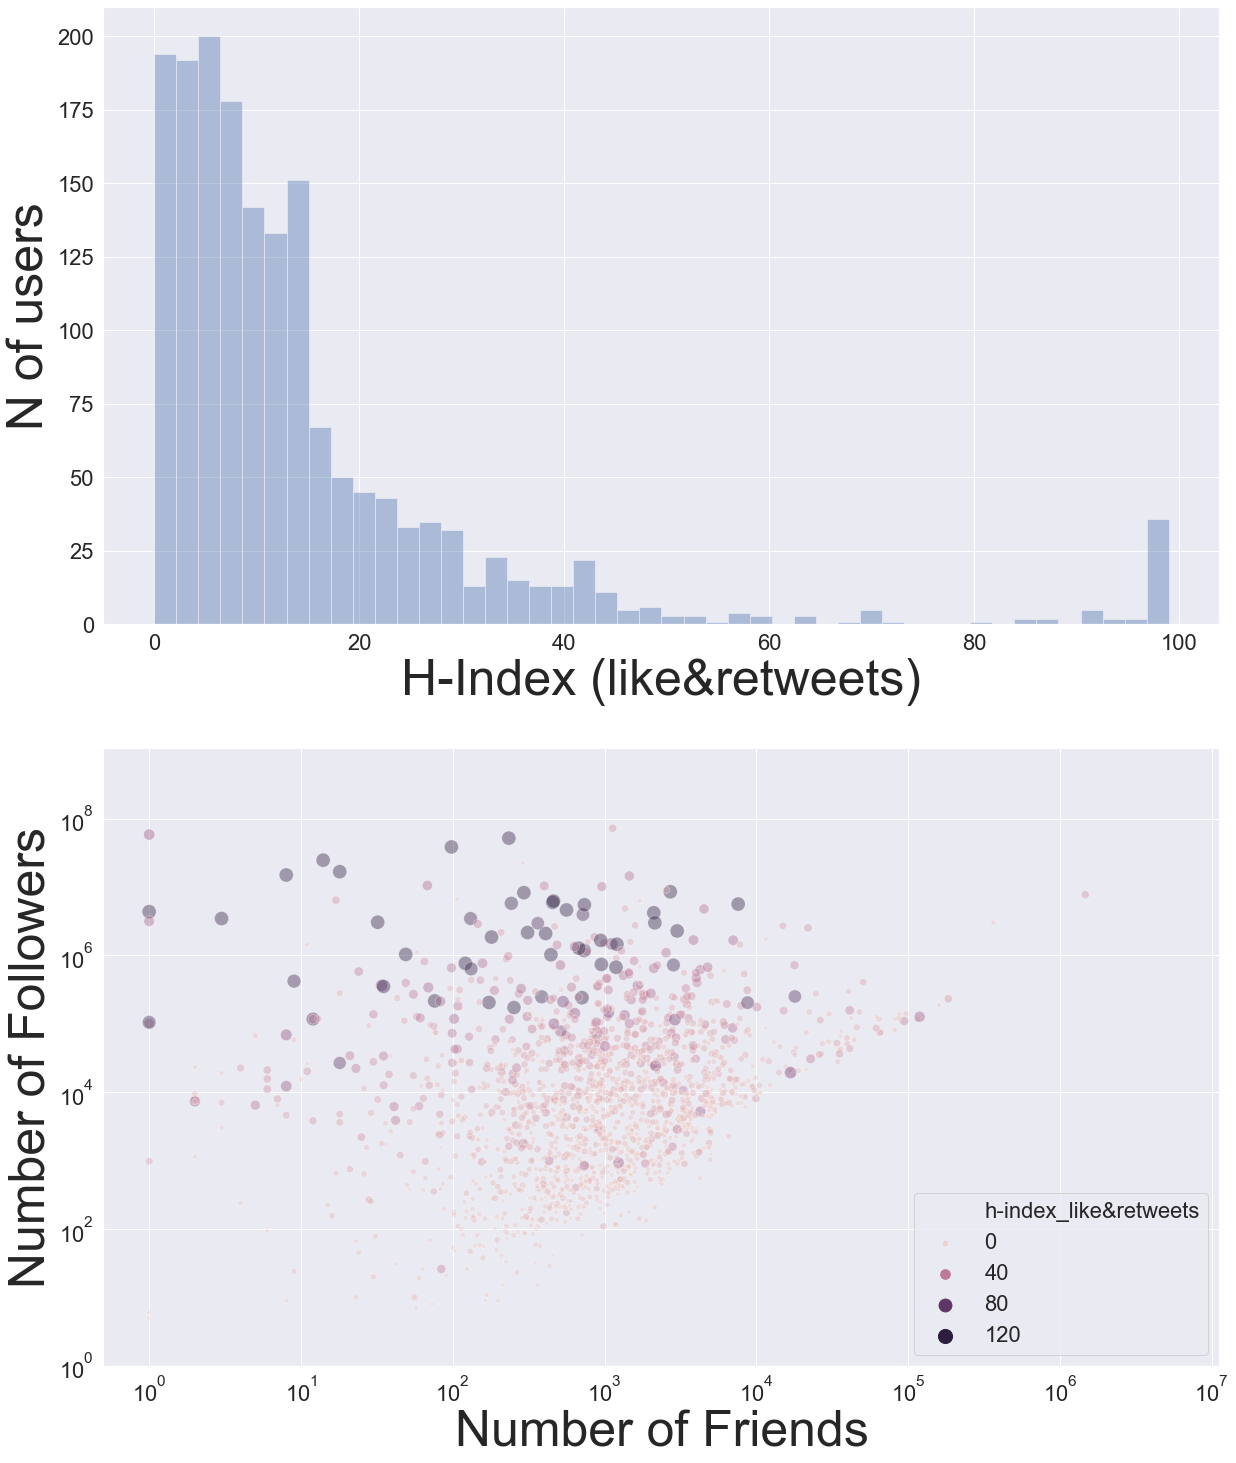

In [5]:
from src.data import H_Index_tools as h_tools
h_tools.plot_H_index(df_users_profiles_metrics)